<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/SMART_CLAIR/blob/main/NOGA_SmartGrid_with_CityLearn_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


---




So far, we got familiar with the citylearn environment in the previous notebooks and analyzed its data. It is now time to see how we support decision-making using various AI methods and how we optimize agent behavior.


In a single agent setting, given the environment, we have an agent, i.e., a decision-making procedure, that decides at each time step what is the right action to perform. In the citylearn setting, this can correspond to a single procumer deciding about its battery charging/discharging policy while considering the other elements of the grid as part of the (non-stationary) environment.

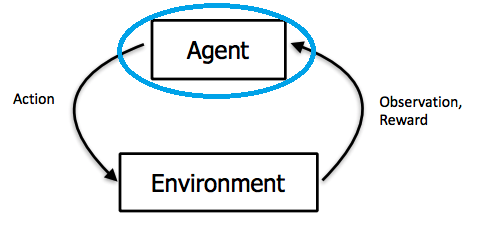

Under some circumstances, it makes sense to model the environment as a multi-agent setting. This includes centralized control settings where there are multiple agents but only one (central) decision-making procedure, and decentralized settings where each agent has its decision-making procedure and possibly non-aligned rewards. In some cases, even if it is possible to control agents in a centralized architecture, it is more efficient to apply a decentralized setting.

In any case, the dynamics of the system can be depicted as follows.

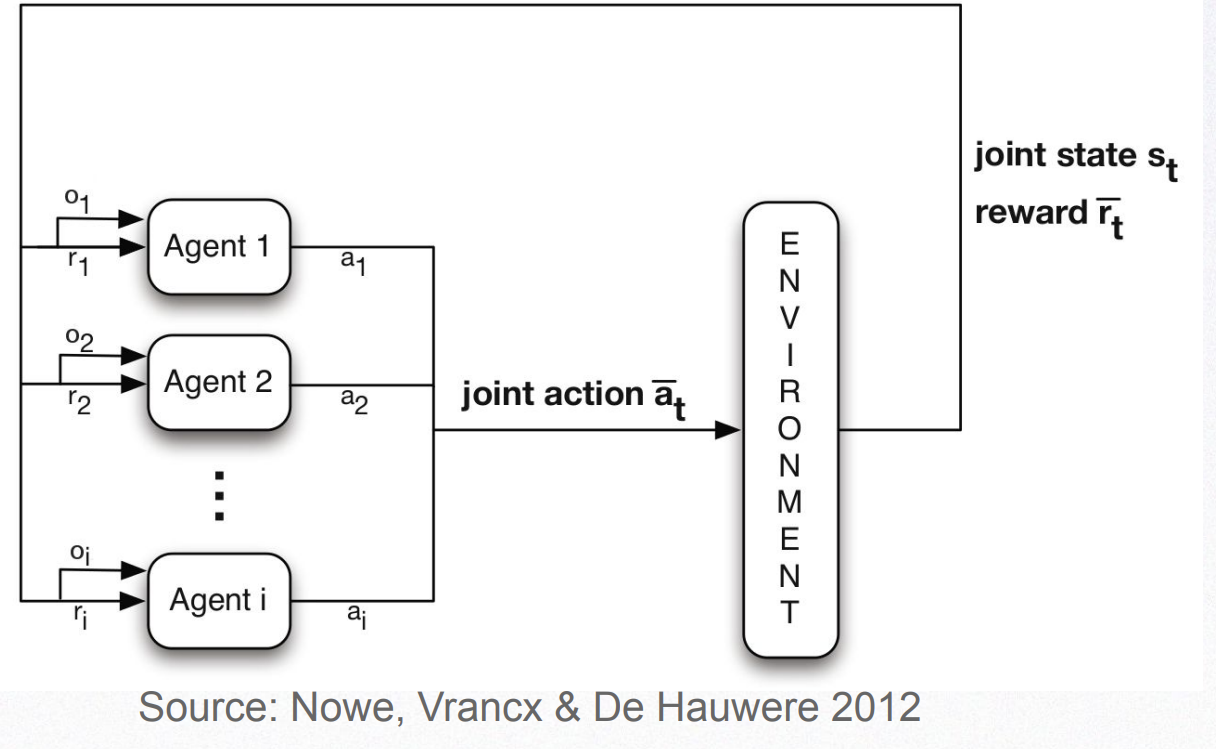

As shown above, at each time step, each agent is associated with an action (which can be a no-op). All actions of all agents are synchronously applied to the environment as a joint action. This results in the emission of an observation and reward signal sent to each agent.

<a name="software-requirements"></a>
# Software Requirements
---

This section installs and imports the software packages that will be used in the remainder of the tutorial. We start off by comparing the Python version of this current environment. CityLearn and its dependencies will work with `python>=3.7.x`

The Python version of this environment is:

In [ ]:
!python --version


In order to run a simulation we need to install the environment and some libraries we will use.

In [ ]:
!pip install -q CityLearn # the -q argument is for not printing the installation process to the screen.

                          # please ignore (if occurs) the following installation error "ERROR: pip's dependency resolver..."
                          # which is a results of torch version being uncompatible with colab,
                          # as long as we do not use PyTorch (in example, for Reinforcement Learning) you
                          # shouldn't be concerned abount it.

We can also instal a specific version if needed.

In [ ]:
# The environment we will be working with
#!pip install CityLearn==1.8.0


The following Python packages are required:

In [ ]:
# for installing packages using legacy code
!pip install setuptools==65.5.0

# For participant interactions (buttons)
!pip install ipywidgets==7.7.2

# To generate static figures
!pip install matplotlib==3.5.3
!pip install seaborn==0.12.2

# For visualization
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb

# Provide standard RL algorithms
!pip install "stable-baselines3[extra]>=2.0.0a4"

We also need to import the following modules.

In [ ]:
# System operations
import os
import warnings
warnings.filterwarnings('ignore')

# type hinting
from typing import List, Mapping, Tuple

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML, IntProgress

# Data manipulation
import itertools
import math
import numpy as np
import pandas as pd
import random

# CityLearn
from citylearn.agents.base import Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.wrappers import NormalizedObservationWrapper, DiscreteActionWrapper, TabularQLearningWrapper, StableBaselines3Wrapper

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.optim import Adam


# Gym
import gym
from gym import ActionWrapper, spaces
from gym.spaces import Discrete, Box


# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

# Running a Simulation
---





To examine the performance of agents we run a *simulation*. This means we emulate the interaction with the environment for some number of episodes.
Typically, the interaction with the RL agent consists of two main parts: training and evaluation.
During training, the agent learns to operate efficiently in the environment and updates its policy, which is a mapping from states (or observations) to actions.
 For evaluation, the policy is typically fixed, and the agent's performance is measured according to the relevant perfrmance criteria or Key Performance Indicators (KPI)s.



Typically, we want to examine performance over time (or any other training resource), so we examine the performance of the policy at preset intervals.

**Step \#1: Initialize the CityLearn Environment**


To initialize an instance of the CityLearn environment we need to call the `citylearn.citylearn.CityLearnEnv.__init__` method and process the data using the `schema` file.



We choose which dataset to use (e.g.'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_all'). To start off, it's best to use the phase_1 dataset - so that things run quickly.

In [ ]:
dataset_name = 'citylearn_challenge_2022_phase_1'
#dataset_name = 'citylearn_challenge_2022_phase_all'

We initialize the CityLearn environment with the data set.


In [ ]:
env = CityLearnEnv(dataset_name)

The following displays the observation elements.

In [ ]:
obs_elements = []
for item in env.schema['observations'].items():
  if item[1]['active'] == True:
    print(item[0])

When the environment is loaded, the various buildings are initialized. The following shows the initial values of the building features.

In [ ]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage capacity history:', {
    b.name: b.electrical_storage.capacity_history for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage efficiency history:', {
    b.name: b.electrical_storage.efficiency_history for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})

For running the simulation, we reset the environment and define the data items we want to collect.

In [ ]:
# reset the environment
joint_observation = env.reset()

n_steps = 96      # set the number of steps (hours in the simulation, i.e. 24 is a whole single day)
solargen_obs_idx = -7      # the index of the observation variable to plot (-6 => "electrical_storage_soc"
                  #                                                -7 => "solar_generation"...)
net_con_idx = -5 # net consumption intex

building_i = 0    # index of the building for which to plot the data

# constainers used to collect data during execution
environment_data_to_plot = []
performance_data_to_plot = []

# add the initial observation to the data
environment_data_to_plot.append(joint_observation[building_i][solargen_obs_idx])
performance_data_to_plot.append(joint_observation[building_i][net_con_idx])

# number of buildings in the environment
n_buildings = len(joint_observation)


For demonstration purposes, we now run a simulation using random action selection as the decision-making procedure.

In [ ]:
# run through the environment manually
for _ in range(n_steps - 1):

  # sample random actions for each building (here - the charge and discharge values)
  joint_action = [[random.uniform(-1, 1)] for _ in range(n_buildings)]

  # step the environmnet
  next_joint_observation, reward, info, done = env.step(joint_action)

  # collect the data
  environment_data_to_plot.append(next_joint_observation[building_i][solargen_obs_idx])
  performance_data_to_plot.append(next_joint_observation[building_i][net_con_idx])


The step action takes as input the action of each agent and returns a list of their observations and rewards.



```

    def step(self, actions: List[List[float]]) -> Tuple[List[List[float]], List[float], bool, dict]:
        """Apply actions to `buildings` and advance to next time step.


        actions = self.__parse_actions(actions)

        for building, building_actions in zip(self.buildings, actions):
            building.apply_actions(**building_actions)

        self.next_time_step()
        reward = self.reward_function.calculate()
        self.__rewards.append(reward)
        return self.observations, reward, self.done, self.get_info()

```



Initial values of the variables that are monitored

In [ ]:
print(environment_data_to_plot[0])
print(performance_data_to_plot[0])

We now plot the data collected


In [ ]:
# plotting the data collected
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title(f"Data collected from observation[{solargen_obs_idx}] (solar generation) for building-{building_i}")
ax.plot(range(n_steps), environment_data_to_plot, '-o', label='data')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Value")
ax.grid()
ax.legend()
plt.show()

In [ ]:
# plotting the data collected
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title(f"Data collected from observation[{net_con_idx}] (net consumption) for building-{building_i}")
ax.plot(range(n_steps), performance_data_to_plot, '-o', label='data')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Value")
ax.grid()
ax.legend()
plt.show()

# Evaluating Performance Using Key Performance Indicators (KPI)

In the example above, we plotted the observations collected from the environment and the agent. The citylearn framework provides additional performance indicators, or Key Performance Indicators (KPIs) to monitor an agent's performance (more on this later on).

The way performance is evaluated is dictated by the different cost functions, or KPIs, for which values are computed (see the notebook on the citylearn environment for more details).

The different cost functions can be found at citylearn.cost_function.py. For example, electricity_consumption
is computed as follows.

```
data = pd.DataFrame({'net_electricity_consumption':np.array(net_electricity_consumption).clip(min=0)})
        data['electricity_consumption'] = data['net_electricity_consumption'].rolling(window=data.shape[0],min_periods=1).sum()
        return data['electricity_consumption'].tolist()
```


Here, we will use KPI's that are to be **minimized**: electricity consumption, cost, carbon emissions, average daily peak, ramping, and (1 - load factor). Average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E^t$. Electricity consumption, cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $e^{i,t}$, and are reported at the grid level as the average of the building-level values.


Electricity consumption for building i is defined as the sum of imported electricity $e^{i,t}$.

$$
    \textrm{electricity consumption} = \sum_{t=0}^{n-1}{\textrm{max} \left (0,e^{i,t} \right)}
$$

Cost is defined as the sum of building-level imported electricity cost, $e^{i,t} \times R^{t}$ (\$), where $R^{t}$ is the electricity rate at hour $t$.

$$
    \textrm{cost} = \sum_{t=0}^{n-1}{\textrm{max} \left (0,e^{i,t} \times R^{t} \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $e^{i,t} \times O^t$, where $O^t$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $t$.

$$
    \textrm{carbon emissions} = \sum_{t=0}^{n-1}{\textrm{max} \left (0,e^{i,t} \times O^t \right )}
$$

Average daily peak, is defined as the mean of the daily $E^{t}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{t=0}^{23} {\textrm{max} \left (E^{24d + t}, \dots, E^{24d + t} \right)}
    }{n}
$$

Ramping is defined as the absolute difference of consecutive $E^{t}$. It represents the smoothness of the district’s load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{t=0}^{n-1}  \lvert E^{t} - E^{t - 1} \rvert
$$

Load factor is defined as the average ratio of monthly average and peak $E^{h}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E^{d \cdot m + t}\right) \div d
        }{
            \textrm{max} \left (E^{d \cdot m}, \dots, E^{d \cdot m + d - 1}\right )
    }\Big) \div n
$$

Hereon, KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

Electricity consumption is defined as the sum of imported electricity $e^{i,t}$.

$$
    \textrm{electricity consumption} = \sum_{t=0}^{n-1}{\textrm{max} \left (0,e^{i,t} \right)}
$$

Cost is defined as the sum of building-level imported electricity cost, $e^{i,h} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,e^{i,h} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $e^{i,h} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,e^{i,h} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

Ramping is defined as the absolute difference of consecutive $E_h^{\textrm{district}}$. It represents the smoothness of the district’s load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{h=0}^{n-1}  \lvert E_{h}^{\textrm{district}} - E_{h - 1}^{\textrm{district}} \rvert
$$

Load factor is defined as the average ratio of monthly average and peak $E_{h}^{\textrm{district}}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E_{d \cdot m + h}^{\textrm{district}}
            \right ) \div d
        }{
            \textrm{max} \left (E_{d \cdot m}^{\textrm{district}}, \dots, E_{d \cdot m + d - 1}^{\textrm{district}} \right )
    }\Big) \div n
$$

Hereon, KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

The key performance indicators (KPI) we use here are adopted from
- [link to the tutorial that includes the definition of KPI](https://www.climatechange.ai/papers/iclr2023/2)

**Note!**
The `evaluate` function in the environment calculates and returns the cost functions at the building level and district level, which are normalized with respect to the no-control scenario (baseline). One of the arguments of this function is baseline_condition, which specifies the condition for net electricity consumption, cost, and emissions to be used in calculating the cost functions for the baseline scenario.

The default value for this argument is `EvaluationCondition.WITHOUT_STORAGE_AND_PARTIAL_LOAD_BUT_WITH_PV`, which corresponds to the scenario where none of the storage and cooling, and heating devices in the environment are actively controlled.

It's important to note that all of our Key Performance Indicators (KPIs) are normalized to the baseline scenario. Therefore, the value of the baseline in all of the KPI graphs is 1.

As a reminder, it is important to distinguish between the cost function/KPI which is used to evaluate the agent's performance, and the reward signal which provides the agent with an indication of the progress during execution.

Reward functions are defined at citylearn.reward_function.py.

For example, the basic RewardFunction **citylearn.reward_function.RewardFunction** assigns the following reward at each time step:



```
if self.env.central_agent:
   reward = [min(self.env.net_electricity_consumption[self.env.time_step]*-1, 0)]
else:
  reward = [min(b.net_electricity_consumption[b.time_step]*-1, 0) for b in self.env.buildings]

```



Formally:

$r^{i,t}= \min(-e^{i,t},0)$

This means that if this is a central-agent setting (one decision-maker that controls all agents) agents share a common reward, which is defined as the minimal total electricity consumption. Otherwise, the minimal value of each agent is the reward of each agent.

Another option, **citylearn.reward_function.MARL**, considers the reward to be:
```
district_electricity_consumption = self.env.net_electricity_consumption[self.env.time_step]
building_electricity_consumption = np.array([b.net_electricity_consumption[b.time_step]*-1 for b in self.env.buildings])
reward = np.sign(building_electricity_consumption)*0 01*building_electricity_consumption**2*np.nanmax(0, district_electricity_consumption)
return reward.tolist()
```



Formally:

 $r^{i,t} = sign(-e^{i,t}) \times 0.01(\{{e^{i,t}}\}^2) \times \max(0,E^{t})$


Here, the individual reward is meant to approximate the single agent's contribution to the global reward.

# Helper Functions to Display Simulation Results
---

CityLearn reports the KPIs during simulation using the `citylearn.citylearn.CityLearnEnv.evaluate` (see [docs](https://www.citylearn.net/api/citylearn.citylearn.html#citylearn.citylearn.CityLearnEnv.evaluate)) method. Nevertheless, we define some convenience functions to help us report the KPIs illustratively.

The first function helps us calculate and return the KPIs in a table form.

In [ ]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption', 'cost', 'carbon_emissions',
        'average_daily_peak', 'ramping', '1 - load_factor'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

Next, we have a method for plotting the performance of each building.

In [ ]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(),
                p.get_y() + p.get_height()/2.0,
                p.get_width(), ha='left', va='center'
            )

    plt.tight_layout()
    return fig

In [ ]:
def plot_district_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width(),
            p.get_y() + p.get_height()/2.0,
            p.get_width(), ha='left', va='center'
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [ ]:
def plot_building_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.buildings[i].net_electricity_consumption
            x = range(len(y))
            ax.plot(x, y, label=k)

        y = v.buildings[i].net_electricity_consumption_without_storage
        ax.plot(x, y, label='Baseline')
        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [ ]:
def plot_district_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.net_electricity_consumption
        x = range(len(y))
        ax.plot(x, y, label=k)

    y = v.net_electricity_consumption_without_storage
    ax.plot(x, y, label='Baseline')
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

In [ ]:
def plot_battery_soc_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            soc = np.array(v.buildings[i].electrical_storage.soc)
            capacity = v.buildings[i].electrical_storage.capacity_history[0]
            y = soc/capacity
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

The last function, plot_simulation_summary is a convenience function used to plot all figures in one go:

In [ ]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_building_load_profiles(envs)
    print('Building-level load profiles:')
    plt.show()
    _ = plot_battery_soc_profiles(envs)
    print('Battery SoC profiles:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
    print('District-level load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

We also define a convenience function to set and return a loader i.e. a progress bar as we will use this visualization a number of times to track our learning progress:

In [ ]:
def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

#Using a predefined agent


The citylearn code includes some previously implemented agents, i.e., methods that control the decision-making of the agent.



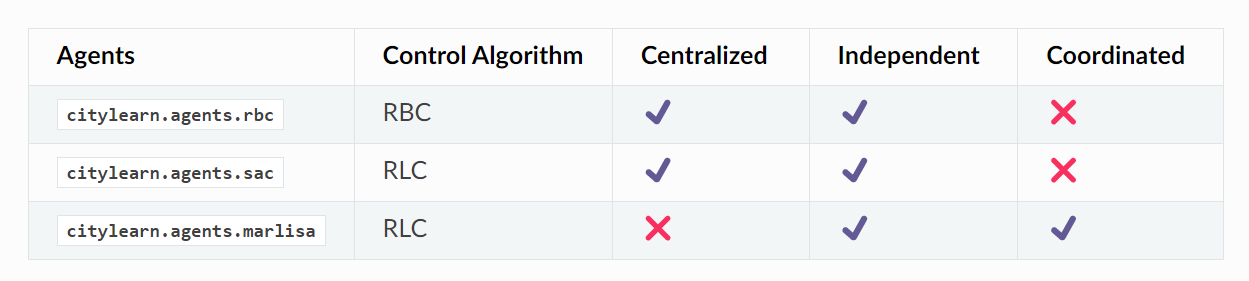

Of course, we can (and will) develop our own agents, but it is useful to know about some basic approaches to decision making.

To initialize an environment, we call the `citylearn.citylearn.CityLearnEnv.__init__` method and parse the `schema` to it:

In [ ]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']
env = CityLearnEnv(schema)


Here, we print some initial values of the environment.

In [ ]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Common (shared) observations amogst buildings:', env.shared_observations)
print('Number of buildings:', len(env.buildings))

To run a simulation, we first need to load the agent that represents the approach by which the decisions are made

In [ ]:
model = env.load_agent()

The agent to be loaded is defined in the schema.json file. Here, the agent that is loaded is a BasicRBC agent.



```
"agent": {
    "type": "citylearn.agents.rbc.BasicRBC",
    "attributes": {
      "hidden_dimension": [
        256,
        256
      ],
      "discount": 0.99,
      "tau": 0.005,
      "lr": 0.003,
      "batch_size": 256,
      "replay_buffer_capacity": 100000.0,
      "start_training_time_step": 6000,
      "end_exploration_time_step": 7000,
      "deterministic_start_time_step": 26280,
      "action_scaling_coef": 0.5,
      "reward_scaling": 5.0,
      "update_per_time_step": 2
    }
  }



One of the actions in the framework (which is the only one that is active by default) defines the amount of electricity that is charged/discharged from the battery. The decision rule here is very simple: the amount is -0.08 (discharge), 0.091 (charge) or 0 (no-op), depending on the hour of day.



```
for n, o, d in zip(self.observation_names, observations, self.action_dimension):
    hour = o[n.index('hour')]

    # Daytime: release stored energy
    if hour >= 9 and hour <= 21:
        a = [-0.08 for _ in range(d)]

    # Early nightime: store DHW and/or cooling energy
    elif (hour >= 1 and hour <= 8) or (hour >= 22 and hour <= 24):
        a = [0.091 for _ in range(d)]

    else:
        a = [0.0 for _ in range(d)]

    actions.append(a)

```




We can change the agent we are using.

In [ ]:
from citylearn.agents.rbc import RBC as RBCAgent
from citylearn.agents.rlc import RLC as RLCAgent

env.reset()
agents = {"RBC": RBCAgent(env), "RLC": RLCAgent(env)}

Now, let's see how to train our agent.
The learning process is detailed in the agent's function **learn** of the agent.

In [ ]:
model.learn(episodes=1, deterministic_finish=False)

The learn method includes an outer loop that runs for the number of episodes specified, and trains the agent for each episodes as follows:



```

            while not self.env.done:
                actions = self.predict(observations, deterministic=deterministic)

                # apply actions to citylearn_env
                next_observations, rewards, _, _ = self.env.step(actions)

                # update
                if not deterministic:
                    self.update(observations, actions, rewards, next_observations, done=self.env.done)
                else:
                    pass

                observations = [o for o in next_observations]



```



As can be seen above, the agent predicts (decides on) the next action to perform, applies it and updates its policy based on the observation and reward recevied. Note that in the case of the BasicRBC agent the agent does not update its policy.

After the agent is done training, it's time to evaluate its performance using both the building and district KPIs.

In [ ]:
print(env.evaluate())

  Now, let's evaluate the performance and plot the performance data.

In [ ]:
observations = env.reset()

while not env.done:
    actions = model.predict(observations, deterministic=True)
    observations, _, _, _ = env.step(actions)


plot_building_kpis({'BasicRBC': env})
print('Building-level KPIs:')
plt.show()

plot_district_kpis({'BasicRBC': env})
print('District-level KPIs:')
plt.show()

Now, let's plot the performance data. This is an indication that 'smarter' agents are needed.


References
- [CityLearn Documentation](https://www.citylearn.net/index.html)
- [CityLearn Related References](https://www.citylearn.net/references.html)

# Writing Your Own Agent

Each agent implemented throughout the tutorial inherits from the agent base class, which is a part of the CityLearn environment. One of the functions of the agent base class is *learn* which is used to train the agent in the environment.

We utilize this function to train our agents.

You can find the complete implementation of the base agent at citylearn.agents.base which inherits from the Environment class.

For example, the RBC (rule-based) agent is implemented as follows.



```
class RBC(Agent):
    r"""Base rule based controller class.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment.

    Other Parameters
    ----------------
    **kwargs : Any
        Other keyword arguments used to initialize super class.
    """

    def __init__(self, env: CityLearnEnv, **kwargs: Any):
        super().__init__(env, **kwargs)

class HourRBC(RBC):
    r"""A time-of-use rule-based controller.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment.
    action_map: Mapping[int, float], optional
        A 24-hour action map where the key is the hour between 1-24 and the value is the action.
        For storage systems, the value is negative for discharge and positive for charge. Will
        return random actions if no map is provided.

    Other Parameters
    ----------------
    **kwargs: Any
        Other keyword arguments used to initialize super class.
    """

    def __init__(self, env: CityLearnEnv, action_map: Mapping[int, float] = None, **kwargs: Any):
        super().__init__(env, **kwargs)
        self.action_map = action_map

    def predict(self, observations: List[List[float]], deterministic: bool = None) -> List[List[float]]:
        """Provide actions for current time step.

        Parameters
        ----------
        observations: List[List[float]]
            Environment observations
        deterministic: bool, default: False
            Wether to return purely exploitatative deterministic actions.

        Returns
        -------
        actions: List[List[float]]
            Action values
        """

        actions = []

        if self.action_map is None:
            actions = super().predict(observations, deterministic=deterministic)

        else:
            for n, o, d in zip(self.observation_names, observations, self.action_dimension):
                hour = o[n.index('hour')]
                a = [self.action_map[hour] for _ in range(d)]
                actions.append(a)

            self.actions = actions
            self.next_time_step()

        return actions
```



## Data Preprocessing

To run a more elaborate agent with the limited resources available here, we will make minor changes to its schema.

These changes are as follows:

1. We use a subset of the buildings so that we are not overwhelmed by the amount of data to analyze. Since CityLearn is primarily designed for district level energy management and coordination we should use more than 1 building.

2. We use only a one-week period from the entire one-year period for the same reason of ease of analysis.

3. Instead of using the [full observation space](https://www.citylearn.net/overview/observations.html) that will take a while to explore in RL implementations, we will narrow down the space to only one observations: `hour`. This is not the best set-up because the hour alone does not explain the state transitions in the environment that the agent is observing. Nevertheless, it will help highlight the strengths and weaknesses of different algorithms.

We will make these modifications directly in the schema. The buildings and one-week period will be pseudo-randomly selected but for reproducibility, we will set the random generator seed. This seed can be changed to any value to select another pseudorandom set of buildings and time period.



In [ ]:
RANDOM_SEED = 42

We will define three functions to help us make these changes.

In [ ]:
NUM_OF_BUILDINGS = 15
NUM_OF_DAYS = 365

In [ ]:
def set_schema_buildings(
schema: dict, count: int, seed: int
) -> Tuple[dict, List[str]]:
    """
    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active buildings set.
    buildings: List[str]
        List of selected buildings.
    """

    assert 1 <= count <= NUM_OF_BUILDINGS, 'Count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    # update schema to only included selected buildings
    for b in schema['buildings']:
        if b in buildings:
            schema['buildings'][b]['include'] = True
        else:
            schema['buildings'][b]['include'] = False

    return schema, buildings

In [ ]:
def set_schema_simulation_period(
    schema: dict, count: int, seed: int
) -> Tuple[dict, int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with `simulation_start_time_step`
        and `simulation_end_time_step` key-values set.
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= NUM_OF_DAYS, 'Count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps

    building_name = 'Building_1'
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # update schema simulation time steps
    schema['simulation_start_time_step'] = simulation_start_time_step
    schema['simulation_end_time_step'] = simulation_end_time_step

    return schema, simulation_start_time_step, simulation_end_time_step

In [ ]:
def set_active_observations(
    schema: dict, active_observations: List[str]
) -> Tuple[dict, List[str]]:
    """Set the observations that will be part of the environment's
    observation space that is provided to the control agent.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    active_observations: List[str]
        Names of observations to set active to be passed to control agent.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active observations set.
    observations: List[str]
        List of active observations.
    """

    active_count = 0
    valid_observations = list(schema['observations'].keys())
    observations = []

    for o in schema['observations']:
        if o in active_observations:
            schema['observations'][o]['active'] = True
            observations.append(o)
            active_count += 1
        else:
            schema['observations'][o]['active'] = False

    assert active_count > 0,\
        'the provided observations are not valid observations.'\
          f' Valid observations in CityLearn are: {valid_observations}'

    return schema, observations

### Setting the Buildings, Time Periods and Observations to use in Simulations from the Schema

Now we can (pseudo)-randomly select buildings and time periods as well as set the active observations we will use:

In [ ]:
# edit next code line to change number of buildings in simulation
building_count = 2

 # edit next code line to change number of days in simulation
day_count = 7

# edit next code line to change active observations in simulation
active_observations = ['hour']

schema, buildings = set_schema_buildings(schema, building_count, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, day_count, RANDOM_SEED)
schema, active_observations =\
    set_active_observations(schema, active_observations)

print('Selected buildings:', buildings)
print(
    f'Selected {day_count}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', active_observations)

Lastly, the choice between either control strategy is set using the `central_agent` parameter in CityLearn, which is a key-value in the `schema`. We set the `central_agent` key-value in the schema to `True` to define an environment that uses one agent to control many buildings (centralized control strategy):

In [ ]:
schema['central_agent'] = True

# CityLearn Tabular Q-Learning Implementation


---



## Q-Learning Background
[Tabular Q-Learning](https://link.springer.com/article/10.1007/BF00992698#citeas) is a model-free reinforcement learning technique which is popular thanks to its simplicity. In simple tasks with small finite state sets, and discrete actions, all transitions can be represented using a table, hence the name Tabular Q-Learning, which stores the state-action values, i.e., Q-values.

After taking an action $a$, given a state $s$, and observing the immediate reward $r$ for taking $a$ at $s$, learning is achieved through updating $Q(s, a)$ ([Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation)) as:

$$
Q(s, a) = Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
$$

where $Q(s, a)$ is the Q-value for taking action $a$ in state $s$, $\alpha ∈ [0, 1]$ is the learning rate, which explicitly defines to what degree new knowledge overrides old knowledge: for $\alpha = 0$, no learning happens, while for $\alpha = 1$, all prior knowledge is lost. $\gamma$ is the discount factor which allow to balance between an agent that considers only immediate rewards ($\gamma$ = 0) and one that strives towards long term rewards ($\gamma$ = 1). $\max_{a'} Q(s', a')$ is the maximum Q-value for all actions $a'$ in the next state $s'$ that is reached after taking action $a$ in state $s$.

In other words, an optimal policy, $\pi$, results from taking those actions $a$ that maximize the respective Q-values in each state, $s$. In order for the algorithm to converge to an optimal policy, the requirement are that each state-action pair $(s, a)$ be visited infinitely many times, such that the Q-values have converged, and that eventually the agent follows a greedy policy with respect to the learned Q-values (these two principles are called Greedy in the Limit of Infinite Exploration (GLIE)).

## Algorithm

The general Q-Learning algorithm is as follows:

> 1. Initialize the Q-table for all state-action pairs.
> 2. Set the learning rate $\alpha$ ($0 < \alpha < 1$) and the discount factor $\gamma$ ($0 < \gamma < 1$).
> 3. Repeat the following steps for each episode:
>     - Observe the initial state $s$.
>     - Choose an action $a$ based on the epsilon-greedy policy (a random action is chosen with probability epsilon, $\epsilon$ and the action with the highest Q-value is chosen with probability $1 - \epsilon$).
>     - Take the action $a$ and observe the next state $s'$ and the reward $r$.
>     - Update the Q-value of the state-action pair $(s,a)$ using the Bellman equation.
>     - Set $s = s'$.
> 4. Repeat step 3 for a large number of episodes or until convergence is reached.

### Action Selection

In Q-learning, the process of accumulating knowledge happens through the trade-off between exploiting known, high-reward, actions, and exploring other, unknown, actions that have not been executed yet under that state. The $\epsilon$-greedy approach which we use here, selects a random action with probability epsilon, $\epsilon$ (exploration), and the action with the highest expected return with probability $1 - \epsilon$ (exploitation). This balancing allows the agent to avoid local minima (exploration), while striving towards convergence (exploitation). In practice, $\epsilon$ is set relatively large in the beginning of the learning process, and then reduced progressively. The choice of the initial value and the reduction strategy is domain specific and task of the designer.

### Approach Limitations

A caveat of making use of this agent is that it requires discrete observations and actions in order to update the Q-Table whereas the default CityLearn environment provides continuous observations and actions.

CityLearn provides an environment wrapper, `TabularQLearningWrapper` (see [docs](https://www.citylearn.net/api/citylearn.wrappers.html#citylearn.wrappers.DiscreteSpaceWrapper)) used to discretize observations and actions before passing them to an agent. All we need to do is define the number of bins to use to discretize the observations and actions using the wrapper's `observation_bin_sizes` and `action_bin_sizes` initialization variables.


**Note!** This setting affects the dimensions of the action space and observation space. For example, in the `step` function, if central_agent is True, the actions parameter should be a list containing one sublist that includes all buildings' actions by the ordering of the buildings. On the other hand, if central_agent is set to False, the actions parameter should be a list of sublists, where each sublist contains the actions for each building in buildings, following the ordering of the buildings.

This has a direct effect on the basic function of the environment and is one of the most important settings that need to be configured.


### Discretization



We will discretize the hour into 24 bins and the action into 12 bins.
When we discretize the action into 12 bins, it means that we divide the continuous action space into 12 equally spaced intervals or bins. Each bin represents a discrete action that the agent can take. By discretizing the action space, we are essentially reducing the infinite number of possible continuous actions into a finite set of discrete actions. The agent can choose one of these discrete levels to adjust the battery state of each building.

Hour is an observation shared by all buildings. Thus, its values are the same for all buildings at every time step. For this reason, one of the dimensions of our Q-Table will equal the hour bin count.

The action space for controlling the batteries has the same size as the number of buildings. Thus, when discretized the other Q-Table dimensions will equal the electrical_storage action raised to the power of building count.

## Defining our Customized Q-learning Agent and Running It:


We will modify the CityLearn `TabularQLearning` class so that we can visually track the learning process as well as keep tabs on its cumulative reward as training episodes go by. We use the `random_seed` instance variable that we defined earlier. This random seed will ensure that each time this notebook is run, the epsilon-greedy action selections are reproducible.

We define the Tabular Q Learning agent as follows:

In [ ]:
class TabularQLearning(Agent):
    def __init__(
        self, *args, epsilon: float = None, minimum_epsilon: float = None, epsilon_decay: float = None,
        learning_rate: float = None, discount_factor: float = None, q_init_value: float = 0, **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.epsilon = 1.0 if epsilon is None else epsilon
        self.epsilon_init = self.epsilon
        self.minimum_epsilon = 0.01 if minimum_epsilon is None else minimum_epsilon
        self.epsilon_decay = 0.0001 if epsilon_decay is None else epsilon_decay
        self.learning_rate = 0.05 if learning_rate is None else learning_rate
        self.discount_factor = 0.90 if discount_factor is None else discount_factor
        self.q_init_value = np.nan if q_init_value is None else q_init_value
        self.q = self.__initialize_q()


    def predict(self, observations: List[List[float]], deterministic: bool = None) -> List[List[float]]:

        actions = None
        seed = self.random_seed if self.random_seed is None else self.random_seed + self.time_step
        np.random.seed(seed)


        if deterministic or np.random.random() > self.epsilon:
            # Use q-function to decide action
            actions = self.exploit(observations)

        else:
            # Explore random action
            actions = [[s.sample()] for s in self.env.action_space]

        # exponential decay
        episode = int(self.time_step/self.env.time_steps)
        self.epsilon = max(self.minimum_epsilon, self.epsilon_init*np.exp(-self.epsilon_decay*episode))

        self.actions = actions
        self.next_time_step()
        return actions

    def exploit(self, observations: List[List[float]]) -> List[List[float]]:
        actions = []

        for i, o in enumerate(observations):
          o = o[0]
          a = np.argmax(self.q[i][o])
          actions.append([a])
        return actions

    def update(self, observations: List[List[float]], actions: List[List[float]], reward: List[float], next_observations: List[List[float]], done: bool):
        # Compute temporal difference target and error to udpate q-function
        for i, (o, a, r, n) in enumerate(zip(observations, actions, reward, next_observations)):
            o, n, a = o[0], n[0], a[0]
            current_q = self.q[i][o, a]
            next_max_q = np.argmax(self.q[i][n])

            # update q
            new_q = current_q + self.learning_rate*(r + self.discount_factor*next_max_q - current_q)
            self.q[i][o, a] = new_q

    def __initialize_q(self) -> np.ndarray:
        q = [None for _ in self.env.observation_space]
        for i, (od, ad) in enumerate(zip(self.env.observation_space, self.env.action_space)):
            shape = (od.n, ad.n)
            q[i] = np.ones(shape=shape)*self.q_init_value
        return q

 The modifications to the `TabularQLearning` class are done below:

In [ ]:
class CustomTabularQLearning(TabularQLearning):
    def __init__(
        self, env: CityLearnEnv, loader: IntProgress,
        random_seed: int = None, **kwargs
    ):
        r"""Initialize CustomRBC.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        random_seed: int
            Random number generator reprocucibility seed for
            eqsilon-greedy action selection.
        kwargs: dict
            Parent class hyperparameters
        """

        super().__init__(env=env, random_seed=random_seed, **kwargs)
        self.loader = loader
        self.reward_history = []

    def next_time_step(self):
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1
        super().next_time_step()

To start the simulation we first initialize the citylearn environment and the q-learning wrapper:

In [ ]:
tql_env = CityLearnEnv(schema)
# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 12}

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

tql_env = TabularQLearningWrapper(
    tql_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

With our Tabular Q-Learning agent set up, it is time to train it in our environment. We will use the following hyperparameters:

- `epsilon` ($\epsilon$) = 1.0
- `minimum_epsilon` ($\epsilon_{\textrm{min}}$) = 0.01
- `epsilon_decay` ($\epsilon_{\textrm{decay}}$) = 0.0001
- `discount_factor` ($\gamma$) = 0.99
- `learning_rate` ($\alpha$) = 0.005

The agent is trained for $\frac{m \times n \times i}{t}$ episodes where $m$ and $n$ are the observation and action space sizes respectively, $i$ is an arbitrary integer and t is the number of time steps in one episode. That way, we increase the probability that we at least visit each state-action combination once.

In [ ]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i = 5
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', tql_episodes)

# ------------------------------- SET LOADER ------------------------------
loader = get_loader(max=tql_episodes*t)
display(loader)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model = CustomTabularQLearning(
    env=tql_env,
    loader=loader,
    random_seed=RANDOM_SEED,
    **tql_kwargs
)
_ = tql_model.learn(episodes=tql_episodes)

We now evaluate the trained model:

In [ ]:
observations = tql_env.reset()

while not tql_env.done:
    actions = tql_model.predict(observations, deterministic=True)
    observations, _, _, _ = tql_env.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({'TQL': tql_env})

The figures plotted for the Tabular Q-Learning are compared against the baseline. The Q-Learning agent has performed worse than the baseline in terms of the building-level and district-level KPIs. The net electricity consumption profile as a result of the Q-Learning agent shows unstable and spiky consumption. The reason for this behavior is seen in the battery SoC curves where the changes in SoC are abrupt. This highlights an issue with our discretized action space having too large steps as trade off for maintaining a reasonably-sized Q-Table. We also see that the agent did not learn the unique day-to-day building needs as the SoC profile is identical every 24 time steps. This is a consequence of using a single observation, hour to learn.